# Example of the Basic HMM Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import pytz

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Add hidden_regime to path
import sys
sys.path.insert(0, '../')
import hidden_regime as hr
from hidden_regime.models import HiddenMarkovModel, OnlineHMM, OnlineHMMConfig
from hidden_regime.models.config import HMMConfig

## Data Collection

In [3]:
TICKER = 'BTC-USD'
NUM_STATES = 5
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
RANDOM_SEED = 4242

In [4]:
data = hr.load_stock_data(TICKER, START_DATE, END_DATE)

In [5]:
data

,price,date,log_return,volume
0,7083.861694,2020-01-02 00:00:00+00:00,-0.017107,20802083465
1,7164.506104,2020-01-03 00:00:00+00:00,0.011320,28111481032
2,7373.233032,2020-01-04 00:00:00+00:00,0.028717,18444271275
3,7441.700439,2020-01-05 00:00:00+00:00,0.009243,19725074095
4,7592.707886,2020-01-06 00:00:00+00:00,0.020089,23276261598
...,...,...,...,...
359,25588.703125,2020-12-26 00:00:00+00:00,0.058155,48332647295
360,26730.819336,2020-12-27 00:00:00+00:00,0.043666,66479895605
361,26740.595703,2020-12-28 00:00:00+00:00,0.000366,49056742893
362,26950.566895,2020-12-29 00:00:00+00:00,0.007821,45265946774


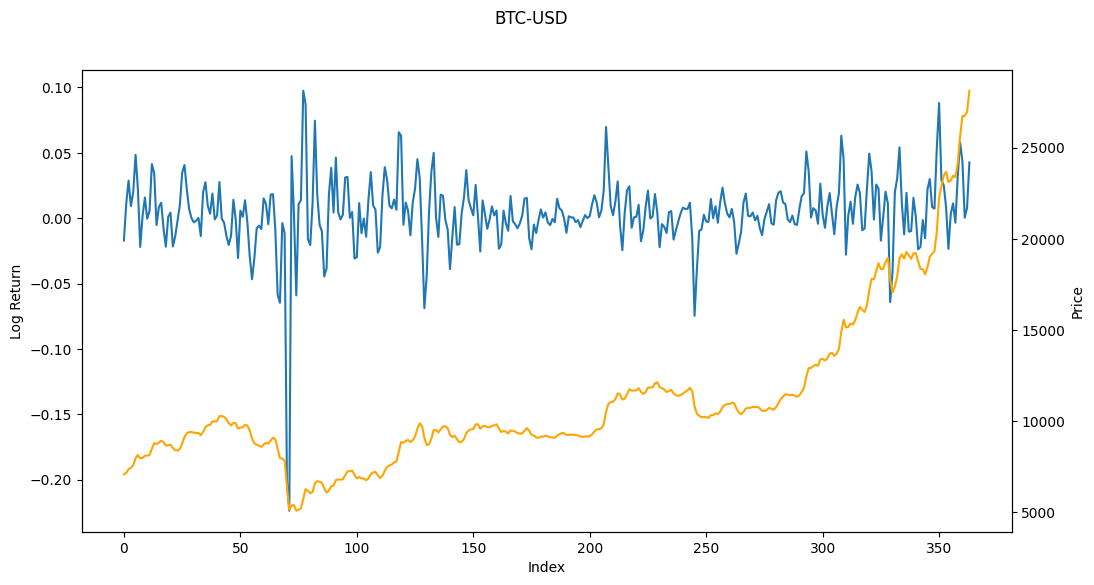

In [6]:
fig = plt.figure()
ax = data.log_return.plot()
ax.set_ylabel('Log Return')
ax.set_xlabel('Index')
ax2 = ax.twinx()
ax2.set_ylabel('Price')
_ = data.price.plot(ax=ax2, color='orange')
_ = fig.suptitle(TICKER)

## HMM Setup

In [7]:
config = HMMConfig.for_standardized_regimes(
    regime_type=f'{NUM_STATES}_state',
    conservative=False
)

print(config)

HMMConfig(n_states=5, max_iterations=100, tolerance=1e-06, regularization=1e-06, initialization_method='kmeans', random_seed=None, min_regime_duration=2, min_variance=1e-08, check_convergence_every=5, early_stopping=True, log_likelihood_threshold=-10000000000.0, regime_type='5_state', auto_select_states=False, state_validation_threshold=0.7, force_state_ordering=True, validate_regime_economics=True)


In [8]:
hmm = HiddenMarkovModel(config=config)

In [9]:
hmm.fit(data.log_return, verbose=True)

Training 5-state HMM on 364 observations
Max iterations: 100, Tolerance: 1e-06
Iteration 0: Log-likelihood = 874.3426, Improvement = inf
Iteration 10: Log-likelihood = 904.6981, Improvement = 0.610585
Iteration 20: Log-likelihood = 914.1952, Improvement = 0.704211
Iteration 30: Log-likelihood = 918.6038, Improvement = 0.323170
Iteration 40: Log-likelihood = 920.7158, Improvement = 0.143556
Iteration 50: Log-likelihood = 921.9043, Improvement = 0.114648
Iteration 60: Log-likelihood = 923.0393, Improvement = 0.106286
Iteration 70: Log-likelihood = 923.9519, Improvement = 0.078274
Iteration 80: Log-likelihood = 924.5584, Improvement = 0.046523
Iteration 90: Log-likelihood = 924.8845, Improvement = 0.022937
Applied state standardization and ordering
Regime validation confidence: 0.932
Training completed in 27.11s
Final log-likelihood: 925.0242


/mnt/c/Workspace/hidden-regime/notebooks/../hidden_regime/models/base_hmm.py:267: UserWarning: HMM did not converge after 100 iterations. Final improvement: 0.010692
  warnings.warn(


HiddenMarkovModel(n_states=5, fitted=True, log_likelihood=925.02)

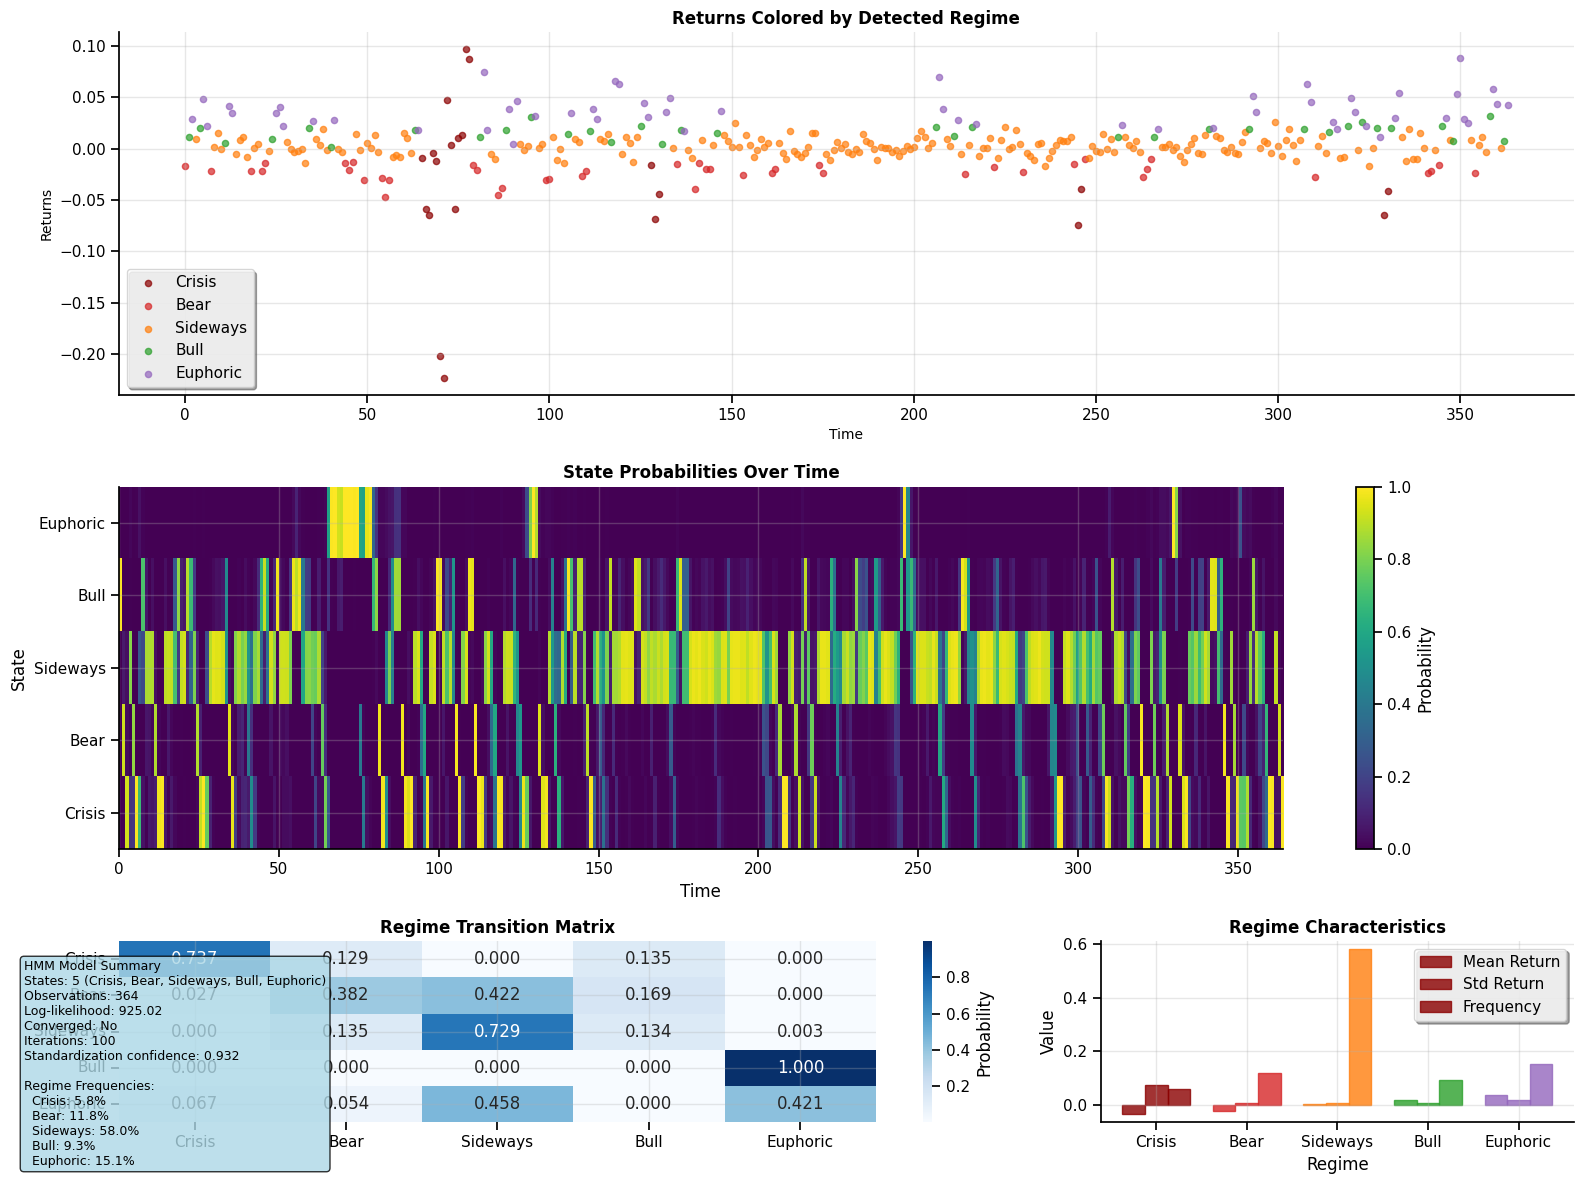

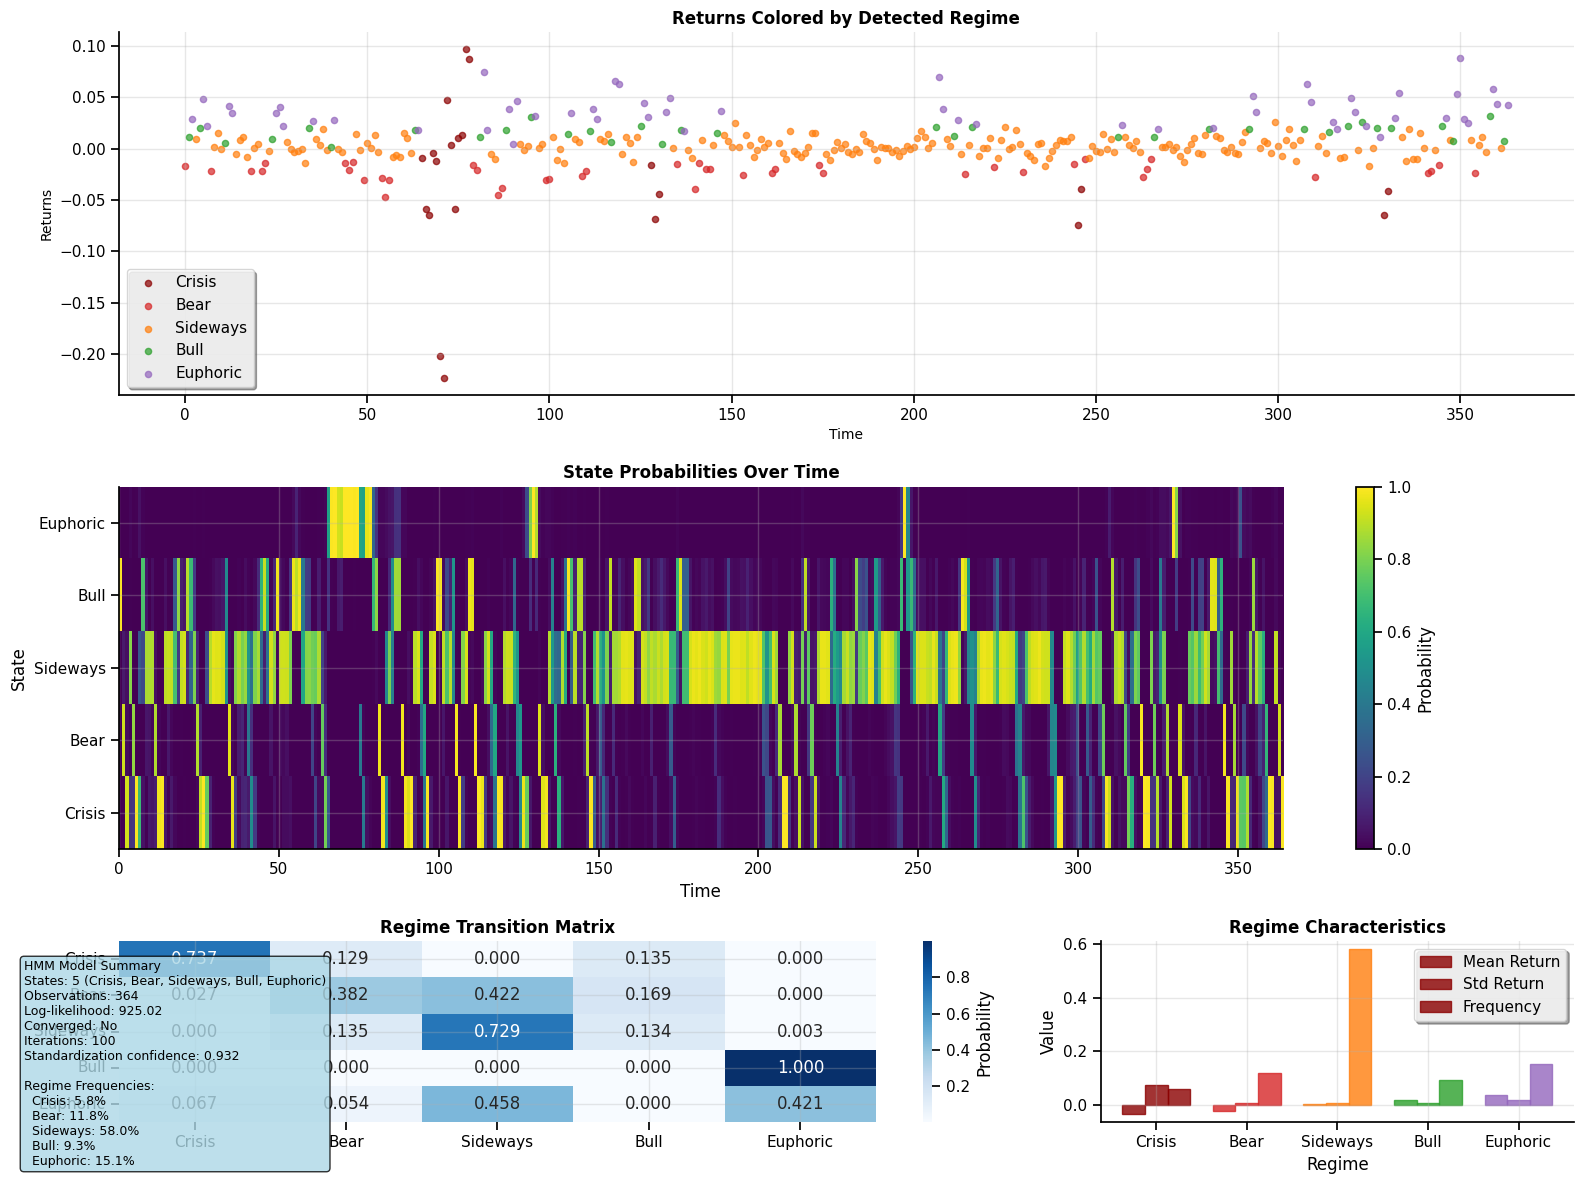

In [10]:
hmm.plot(data.log_return)

In [11]:
hmm.initial_probs_

array([1.13218135e-06, 9.99995753e-01, 1.10616763e-06, 1.00005075e-06,
       1.00810977e-06])

In [12]:
for i in range(NUM_STATES):
    mean, std = hmm.emission_params_[i]
    print(f"     State {i}: mean={mean:.4f}, std={std:.4f}")

     State 0: mean=-0.0314, std=0.0754
     State 1: mean=-0.0189, std=0.0113
     State 2: mean=0.0022, std=0.0087
     State 3: mean=0.0153, std=0.0073
     State 4: mean=0.0319, std=0.0194


In [13]:
hmm.transition_matrix_

array([[7.36561676e-01, 1.28584842e-01, 8.20903577e-08, 1.34853303e-01,
        9.57591696e-08],
       [2.70417859e-02, 3.81632824e-01, 4.22413869e-01, 1.68911492e-01,
        2.91902806e-08],
       [9.48927244e-08, 1.34629285e-01, 7.28765855e-01, 1.34101284e-01,
        2.50348096e-03],
       [9.45824412e-07, 8.40988740e-08, 2.39251905e-06, 8.50334920e-08,
        9.99996493e-01],
       [6.72858922e-02, 5.41075900e-02, 4.57744373e-01, 4.47680899e-08,
        4.20862100e-01]])

## HMM State Prediction

In [14]:
predicted_states = hmm.predict(data.log_return)
state_probabilities = hmm.predict_proba(data.log_return)

In [15]:
price = data.set_index(data.date).price

In [16]:
predicted_state = pd.Series(
    index=data.date, 
    data=predicted_states, 
    name=f'{TICKER}_Predicted_States')

state_probability = pd.DataFrame(
    index=data.date, 
    data=state_probabilities)

In [17]:
latest = predicted_state.index[-1]
output_format = "%m/%d/%Y"
formatted_date = latest.strftime(output_format)
current_state = predicted_state[latest]
mean, std = hmm.emission_params_[current_state]
print(f'Current state for {formatted_date} is: {current_state} (Mean: {mean:.4f}, Std: {std:.4f})')

Current state for 12/30/2020 is: 4 (Mean: 0.0319, Std: 0.0194)


## Data Visualization

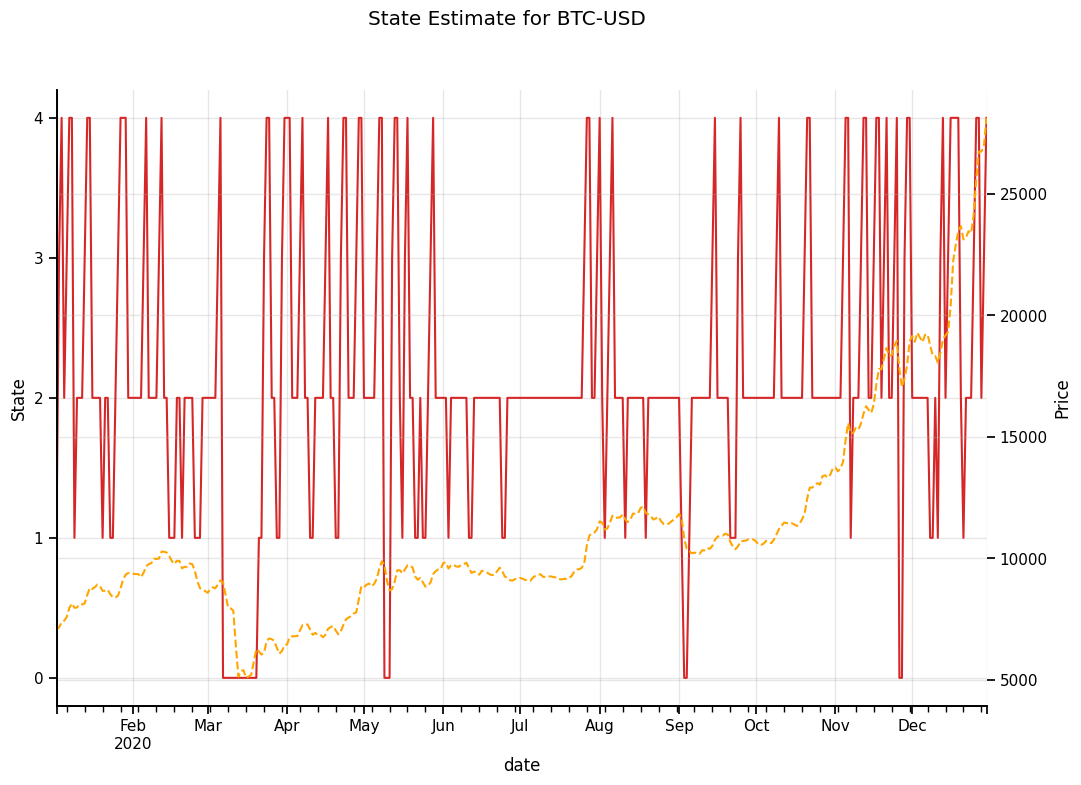

In [18]:
fig = plt.figure()
ax = predicted_state.plot.line()
plt.yticks(list(range(NUM_STATES)))
ax.set_ylabel('State')
ax2 = ax.twinx()
_ = price.plot(ax=ax2, color='orange', style='--')
ax2.set_ylabel('Price')
_ = fig.suptitle(f'State Estimate for {TICKER}')

<Figure size 1200x800 with 0 Axes>

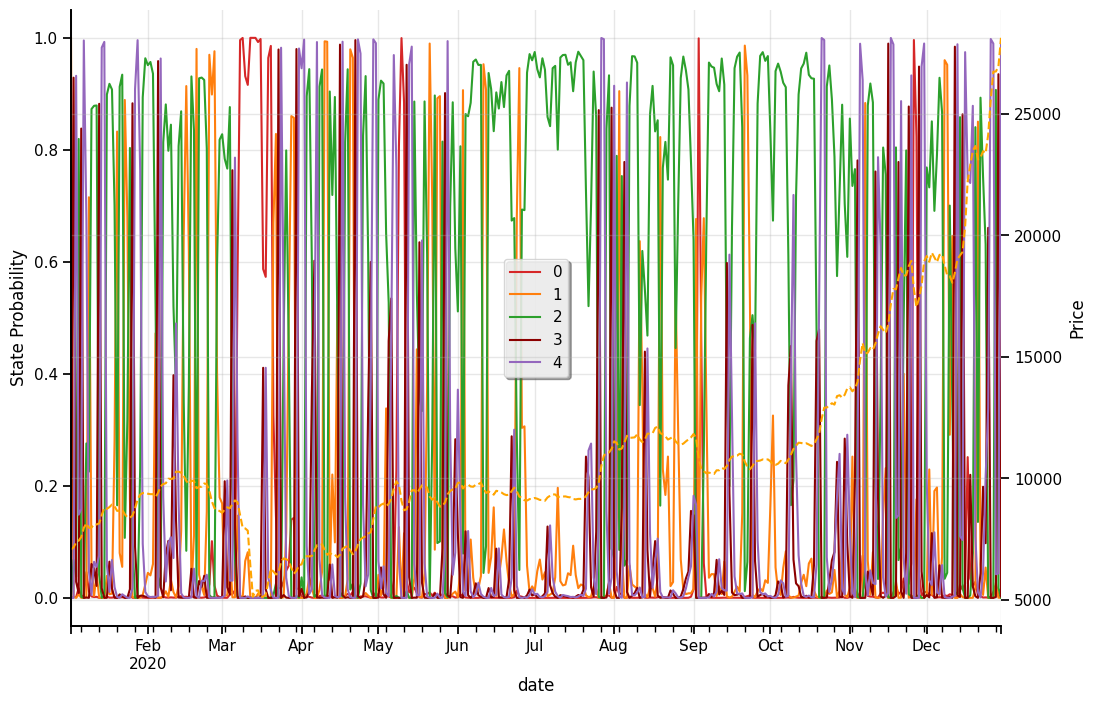

In [19]:
fig2 = plt.figure()
ax = state_probability.plot.line()
ax.set_ylabel('State Probability')
ax2 = ax.twinx()
_ = price.plot(ax=ax2, color='orange', style='--')
_= ax2.set_ylabel('Price')
_ = fig2.suptitle(f'State Probability Estimate for {TICKER}')

Bear
Bull
Euphoric
Sideways
Crisis


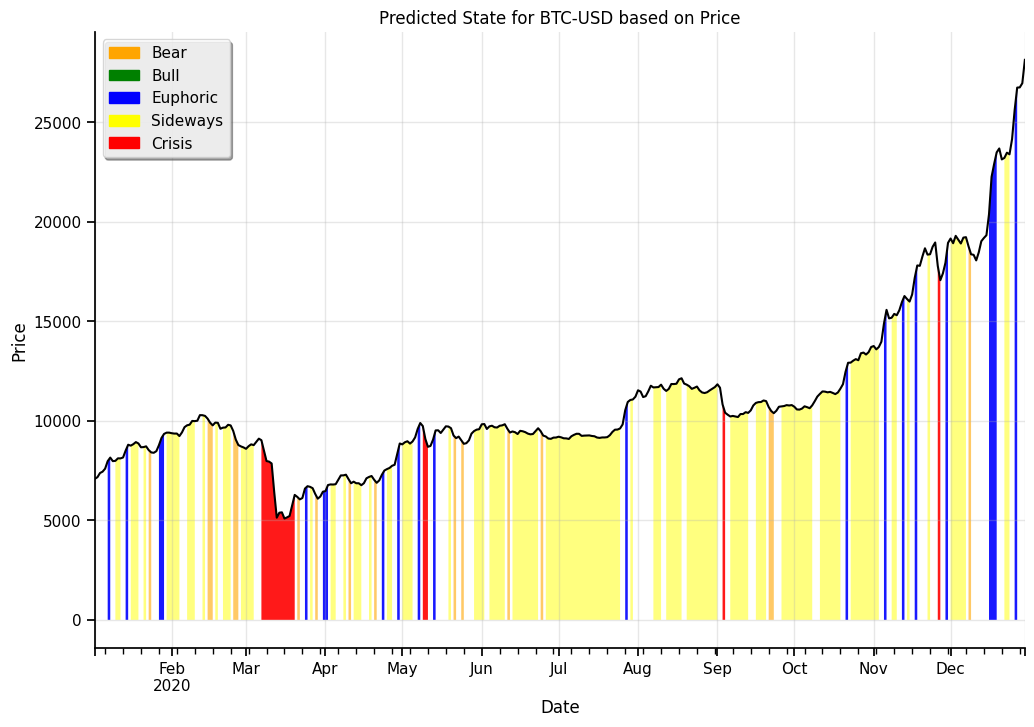

In [20]:
# Assuming 'price' and 'predicted_state' are pandas Series with datetime indexes
# and ax2 is the correct axes object for the price data.

plt.figure(figsize=(12, 8))
ax = price.plot(color='black')
legend_handles = []
legend_labels = []

unique_states = predicted_state.unique()
for state in unique_states:    
    mean, std = hmm.emission_params_[state]
    interpretation = hmm._state_standardizer.get_regime_interpretation_enhanced(state, hmm.emission_params_)
    regime_name = interpretation['regime_name']
    print(regime_name)
    if regime_name == 'Crisis':
        color='red'
        alpha=0.9
    elif regime_name == 'Bear':        
        color='orange'
        alpha=0.6
    elif regime_name == 'Bull':
        color='green'
        alpha=0.6
    elif regime_name == 'Euphoric':
        color='blue'
        alpha=0.9
    else:
        color='yellow'        
        alpha=0.5
        
    # Create a boolean mask to filter data for the current state
    is_state_active = (predicted_state == state)

    # Use fill_between to shade the area under the price curve
    ax.fill_between(
        x=price.index,
        y1=price,  # The price curve
        y2=0,      # The x-axis (or another base line)
        where=is_state_active,
        facecolor=color,
        alpha=alpha
    )

    # Create a legend handle (a colored patch) for the current state
    patch = mpatches.Patch(color=color, 
                           label=f'State {state}')
    legend_handles.append(patch)
    legend_labels.append(f'{regime_name}')

# Add the legend to the price axis
ax.legend(handles=legend_handles, labels=legend_labels)
ax.set_ylabel('Price')
ax.set_xlabel('Date')

plt.title(f'Predicted State for {TICKER} based on Price')

plt.show()

## How it really plays out...

In [21]:
OUTLOOK = timedelta(days=60)
FUTURE_DATE = latest + OUTLOOK
future_formatted_date = FUTURE_DATE.strftime(output_format)
print(f'Examine results from {formatted_date} to {future_formatted_date}')

Examine results from 12/30/2020 to 02/28/2021


In [22]:
future_data = hr.load_stock_data(TICKER, END_DATE, FUTURE_DATE.replace(tzinfo=None))
price_change = np.log(future_data.price / data.price.iloc[-1])

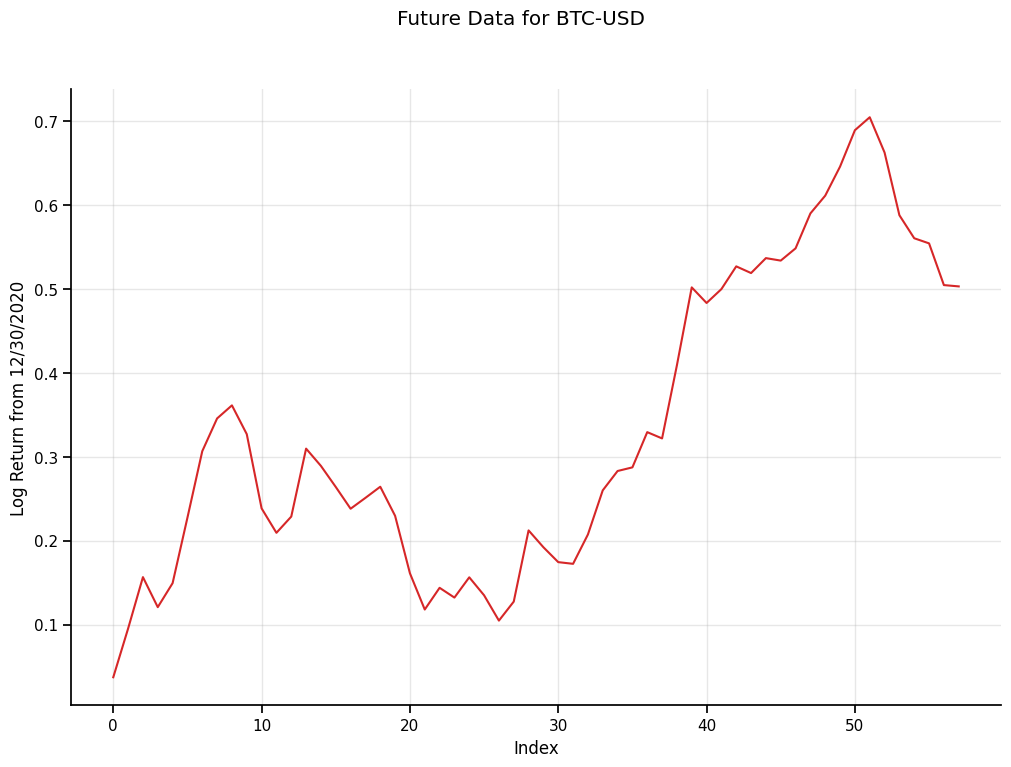

In [23]:
fig = plt.figure()
ax = price_change.plot()
ax.set_ylabel(f'Log Return from {formatted_date}')
ax.set_xlabel('Index')
_ = fig.suptitle(f'Future Data for {TICKER}')

In [24]:
print(f"   ✓ Standardization confidence: {hmm._standardization_confidence:.3f}")
print(f"   ✓ Number of states: {hmm.n_states}")

# Show detected regimes
config_obj = hmm._state_standardizer.current_config
if config_obj:
    print(f"   ✓ Expected regimes: {', '.join(config_obj.state_names)}")
    
    print("   ✓ Detected characteristics:")
    for i in range(hmm.n_states):
        interpretation = hmm._state_standardizer.get_regime_interpretation_enhanced(i, hmm.emission_params_)
        print('-'*25)
        print(f'State: {interpretation['regime_name']}({i})')
        mean, std = hmm.emission_params_[i]
        # Handle numpy int keys in state mapping
        mapped_value = "Unknown"
        if hasattr(hmm, '_state_mapping') and hmm._state_mapping:
            mapped_value = hmm._state_mapping.get(i, hmm._state_mapping.get(np.int64(i), i))
            if isinstance(mapped_value, str):
                regime_name = mapped_value
            elif isinstance(mapped_value, (int, np.integer)) and int(mapped_value) < len(config_obj.state_names):
                regime_name = config_obj.state_names[int(mapped_value)]
            else:
                regime_name = f"State {i}"
        else:
            regime_name = f"State {i}"
        
        print(f"     {regime_name}: μ={mean:.4f}, σ={std:.4f}")

        score = hmm.score(price)
        results = {
            'model': hmm,
            'log_likelihood': score,
            'aic': 2 * (hmm.n_states * (hmm.n_states + 2)) - 2 * score
        }
        
        print(f"   ✓ Log-likelihood: {results['log_likelihood']:.2f}")
        print(f"   ✓ AIC: {results['aic']:.2f}")        
        print(f"   ✓ Duration: {interpretation['expected_duration_days']}")      

   ✓ Standardization confidence: 0.932
   ✓ Number of states: 5
   ✓ Expected regimes: Crisis, Bear, Sideways, Bull, Euphoric
   ✓ Detected characteristics:
-------------------------
State: Crisis(0)
     Crisis: μ=-0.0314, σ=0.0754
   ✓ Log-likelihood: -4448926099112.66
   ✓ AIC: 8897852198295.33
   ✓ Duration: 4.0
-------------------------
State: Bear(1)
     Bear: μ=-0.0189, σ=0.0113
   ✓ Log-likelihood: -4448926099112.66
   ✓ AIC: 8897852198295.33
   ✓ Duration: 8.0
-------------------------
State: Sideways(2)
     Sideways: μ=0.0022, σ=0.0087
   ✓ Log-likelihood: -4448926099112.66
   ✓ AIC: 8897852198295.33
   ✓ Duration: 25.0
-------------------------
State: Bull(3)
     Bull: μ=0.0153, σ=0.0073
   ✓ Log-likelihood: -4448926099112.66
   ✓ AIC: 8897852198295.33
   ✓ Duration: 12.0
-------------------------
State: Euphoric(4)
     Euphoric: μ=0.0319, σ=0.0194
   ✓ Log-likelihood: -4448926099112.66
   ✓ AIC: 8897852198295.33
   ✓ Duration: 6.0
